### Imports and Paths

In [1]:
# Widen Jupyter NB cell display
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# Set-up python print formating
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
import numpy as np, os
import matplotlib.pyplot as plt
import pandas as pd, random
import seaborn as sn
import torch, torch.nn as nn

from PIL import Image
from tqdm import tqdm
from torch.optim import SGD, AdamW
from torch.utils import data
from torchvision import transforms, models
from pydicom import read_file
from pydicom.pixel_data_handlers.util import apply_voi_lut

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/root/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# CHANGE TO YOUR LOCAL
path = "/media/bryan/3777c7d8-50a4-4e8a-9d41-1ac8670b3dd3/vindr/physionet.org/files/vindr-spinexr/1.0.0/"

train_path = path + "train_images/"
test_path  = path + "test_images/"
annot_path = path + "annotations/"

tiny_path = "/".join(path.split("/")[:-2]) + "/tiny_vindr/"
#os.makedirs(tiny_path, exist_ok=True)
#os.makedirs(tiny_path + "train_images/", exist_ok=True)
#os.makedirs(tiny_path + "test_images/", exist_ok=True)
#os.makedirs(tiny_path + "annotations/", exist_ok=True)

## CSV EDA

In [4]:
train_meta = pd.read_csv(path+'/annotations/train.csv')
#print(train_meta.head(20))
print('Unique studies in train:',len(pd.unique(train_meta['study_id'])))
print('Unique series in train:',len(pd.unique(train_meta['series_id'])))
print('Unique images in train:',len(pd.unique(train_meta['image_id'])))

Unique studies in train: 4000
Unique series in train: 5420
Unique images in train: 8389


### View head and tail 20

In [5]:
print(train_meta.tail(10))

                               study_id                         series_id  \
19540  15354677a17156fbb5a617d694f2d25d  1ace0c1895cd8314a54de49ce33777fe   
19541  15354677a17156fbb5a617d694f2d25d  1ace0c1895cd8314a54de49ce33777fe   
19542  15354677a17156fbb5a617d694f2d25d  1ace0c1895cd8314a54de49ce33777fe   
19543  15354677a17156fbb5a617d694f2d25d  1ace0c1895cd8314a54de49ce33777fe   
19544  15354677a17156fbb5a617d694f2d25d  1ace0c1895cd8314a54de49ce33777fe   
19545  15354677a17156fbb5a617d694f2d25d  1ace0c1895cd8314a54de49ce33777fe   
19546  15354677a17156fbb5a617d694f2d25d  1ace0c1895cd8314a54de49ce33777fe   
19547  d7f725fa068661e40db47afaf6811935  ab1126ea55e8423c17b39f1505930c8a   
19548  d7f725fa068661e40db47afaf6811935  4044143ef993d5738d742cb93a418c2c   
19549  d7f725fa068661e40db47afaf6811935  4044143ef993d5738d742cb93a418c2c   

                               image_id rad_id  lesion_type         xmin  \
19540  70845550ebb13ce6863dfaaa20b4289b   rad3  Osteophytes   843.984342   


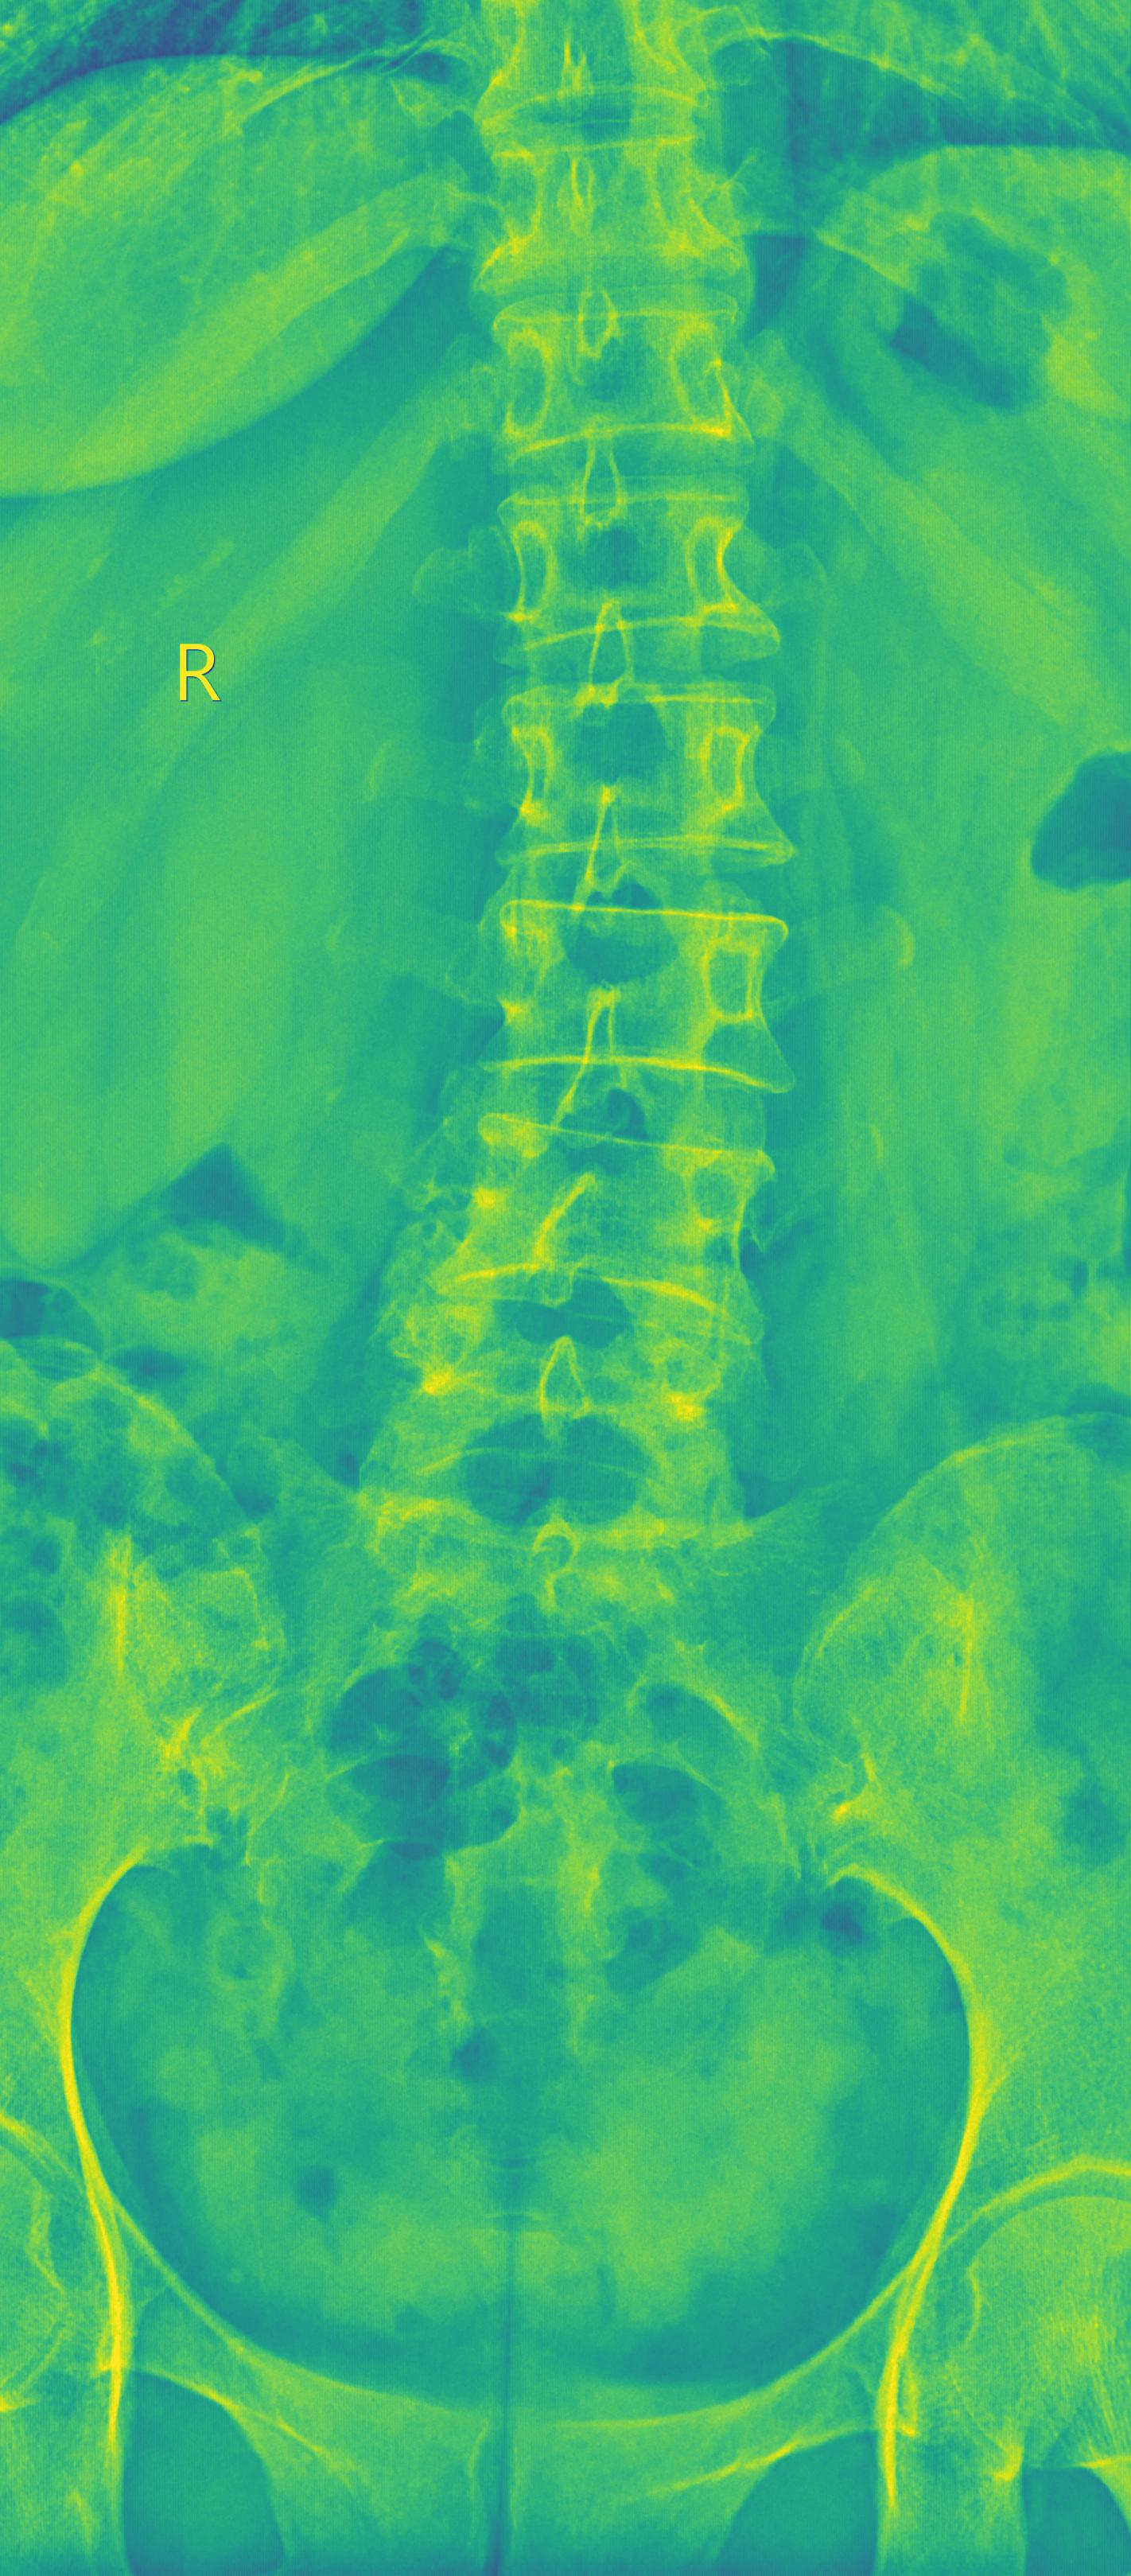

In [10]:
from IPython.display import Image
Image(filename='/media/bryan/3777c7d8-50a4-4e8a-9d41-1ac8670b3dd3/vindr/physionet.org/files/vindr-spinexr/tiny_vindr/train_images/944a3478b664b658389013f512212562.jpg',width=150, height=150)

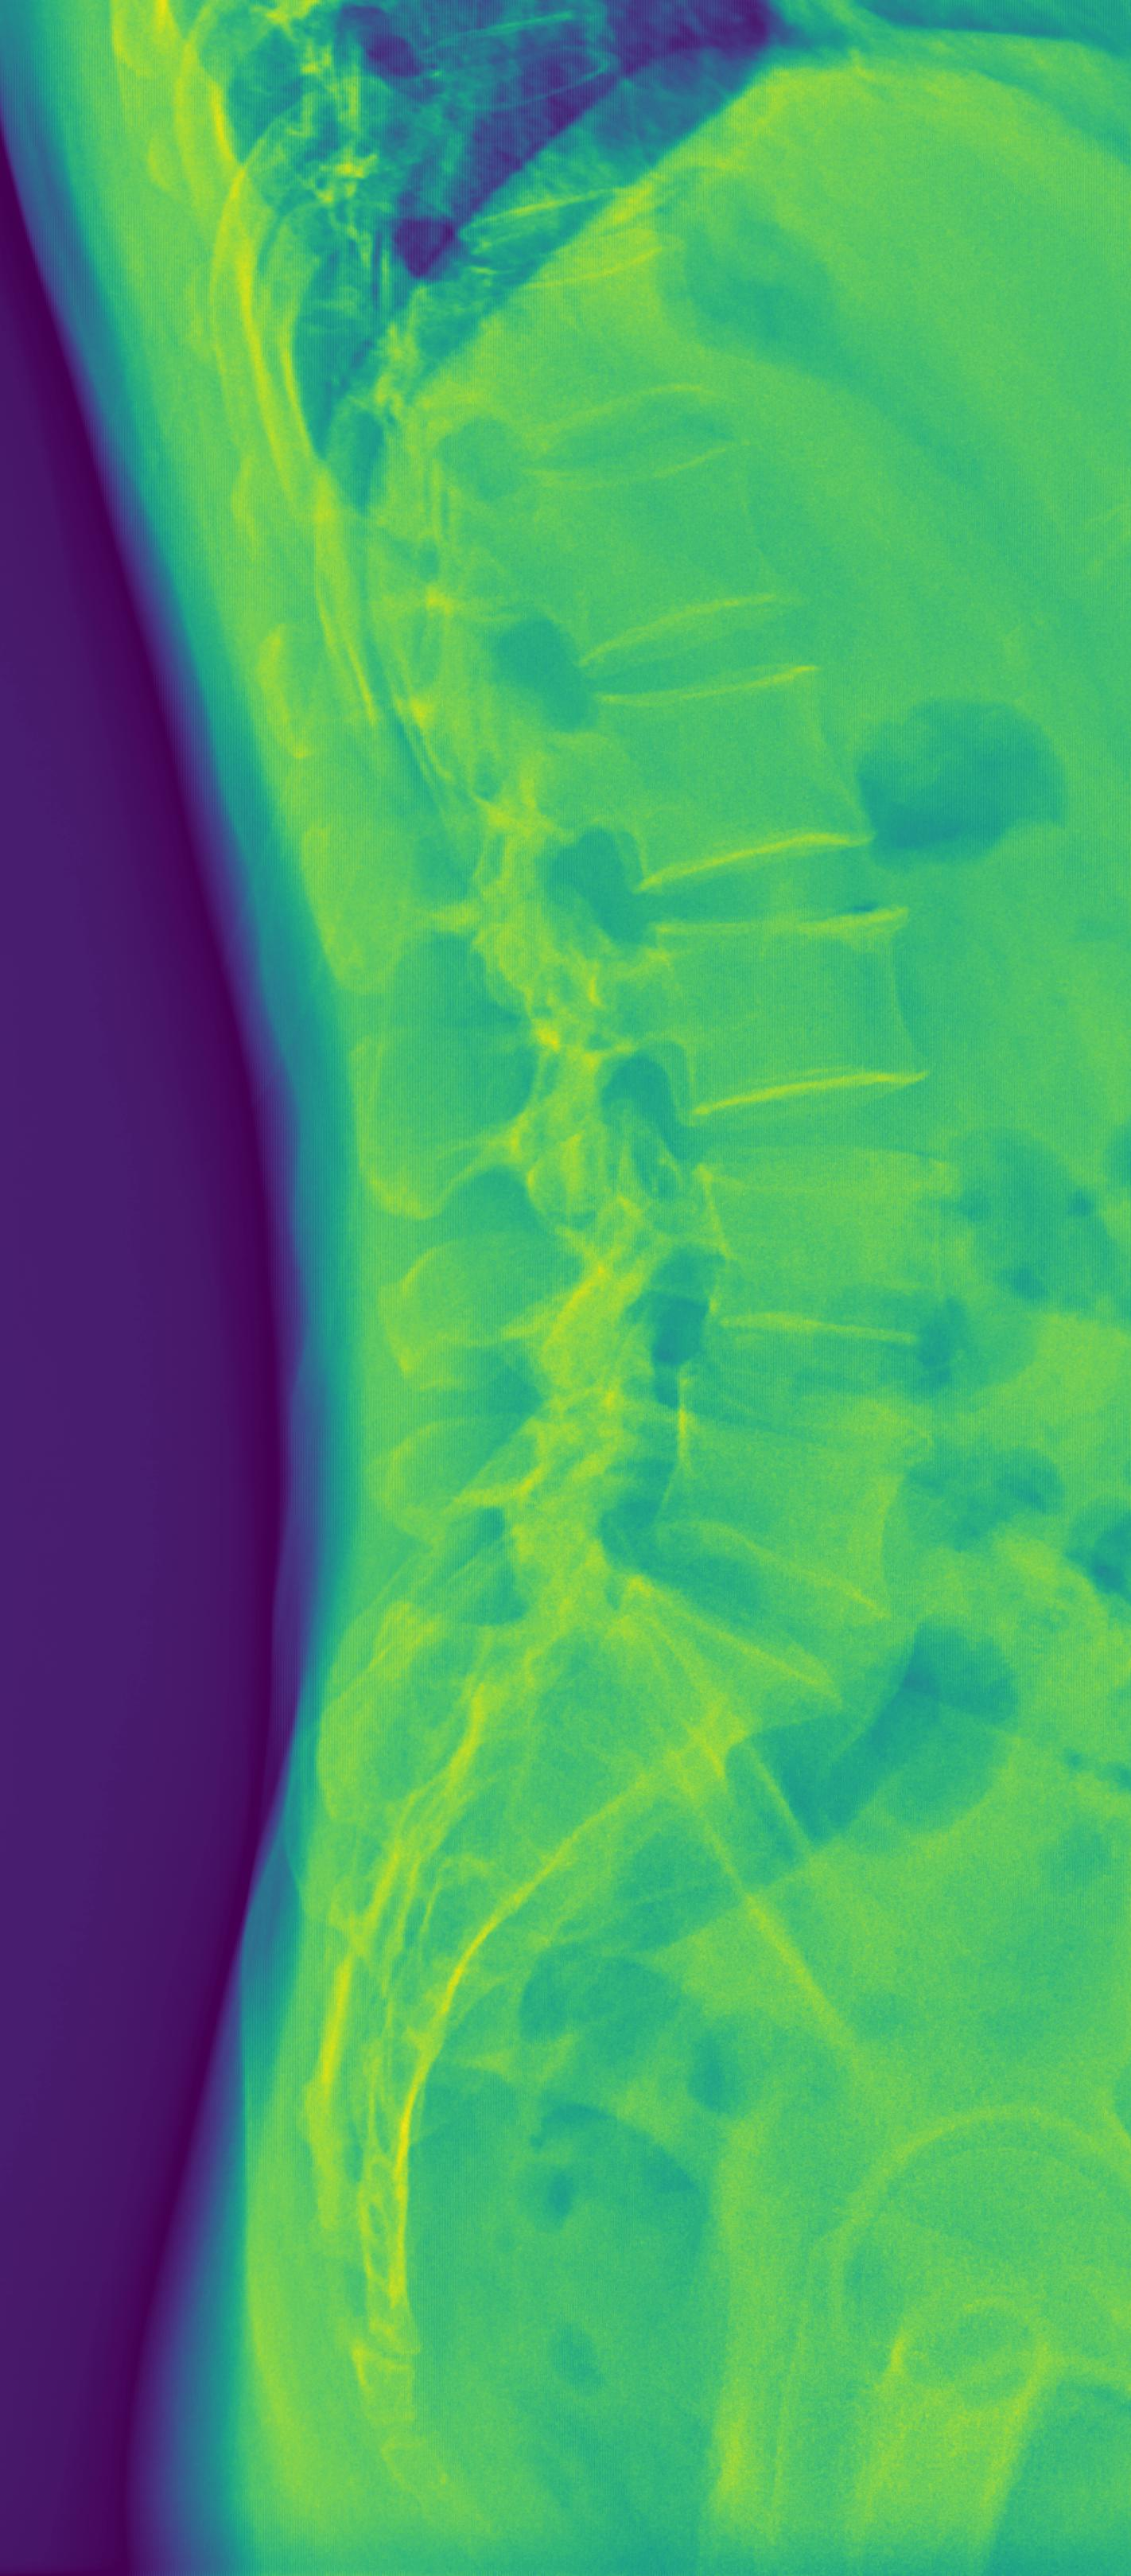

In [12]:
from IPython.display import Image
Image(filename='/media/bryan/3777c7d8-50a4-4e8a-9d41-1ac8670b3dd3/vindr/physionet.org/files/vindr-spinexr/tiny_vindr/train_images/e3b297bc7d0281331a674d107fb5d0eb.jpg',width=150, height=150)

### We see that within the same study id d7f725fa068661e40db47afaf6811935 we have two different series ids ab1126ea55e8423c17b39f1505930c8a and 4044143ef993d5738d742cb93a418c2c. We have three images associated with this study but only two are unique. Therefore, 2+ images may appear as same study id but different series ids.

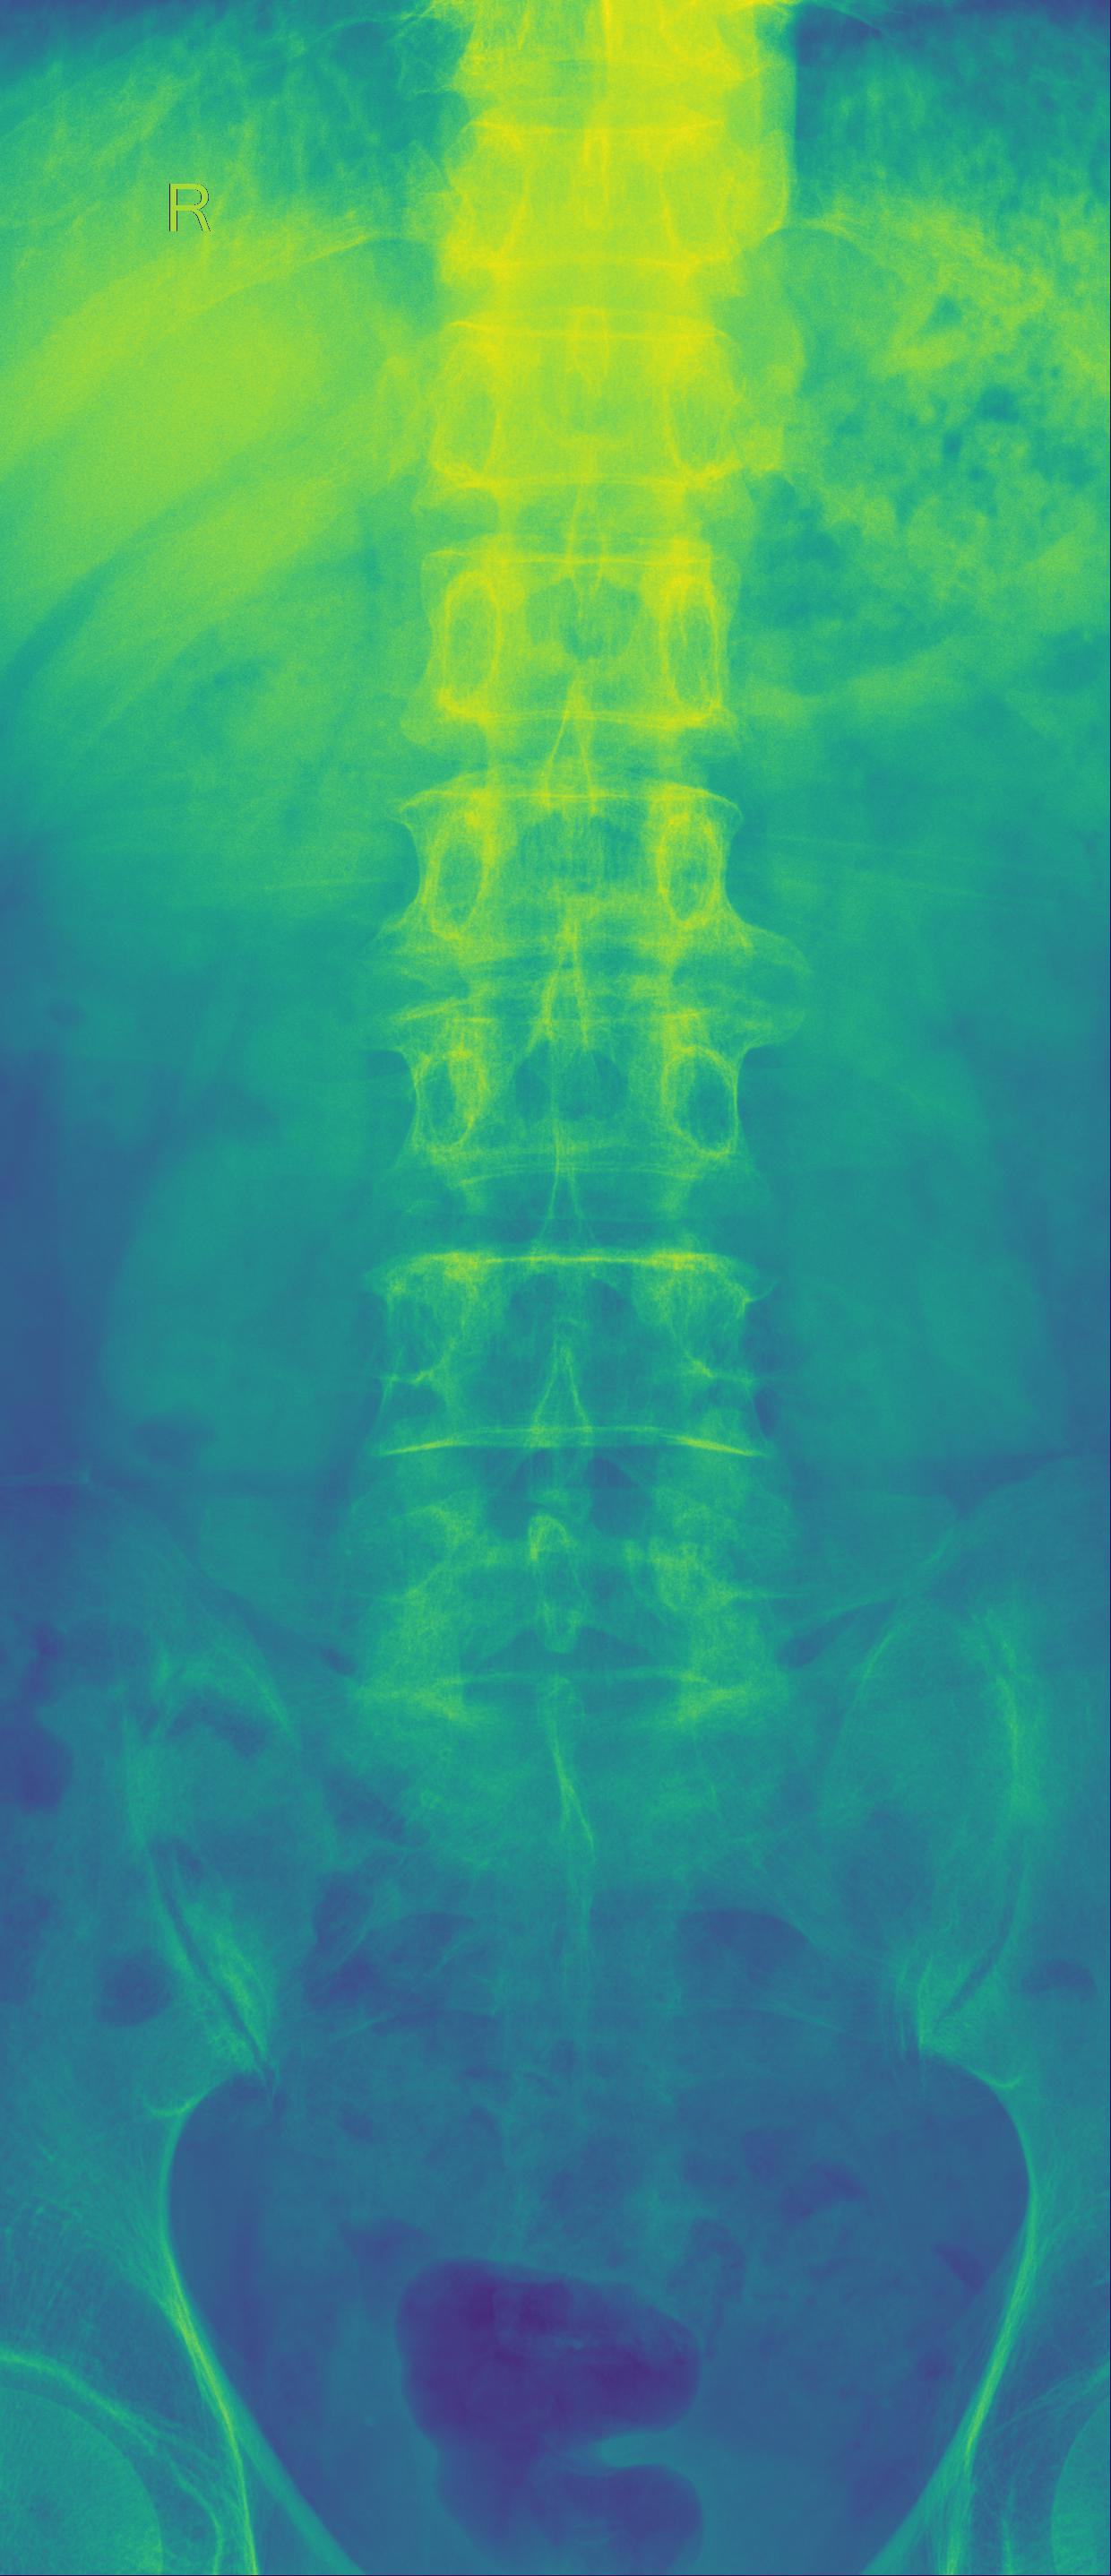

In [13]:
from IPython.display import Image
Image(filename='/media/bryan/3777c7d8-50a4-4e8a-9d41-1ac8670b3dd3/vindr/physionet.org/files/vindr-spinexr/tiny_vindr/train_images/70845550ebb13ce6863dfaaa20b4289b.jpg',width=150, height=150)

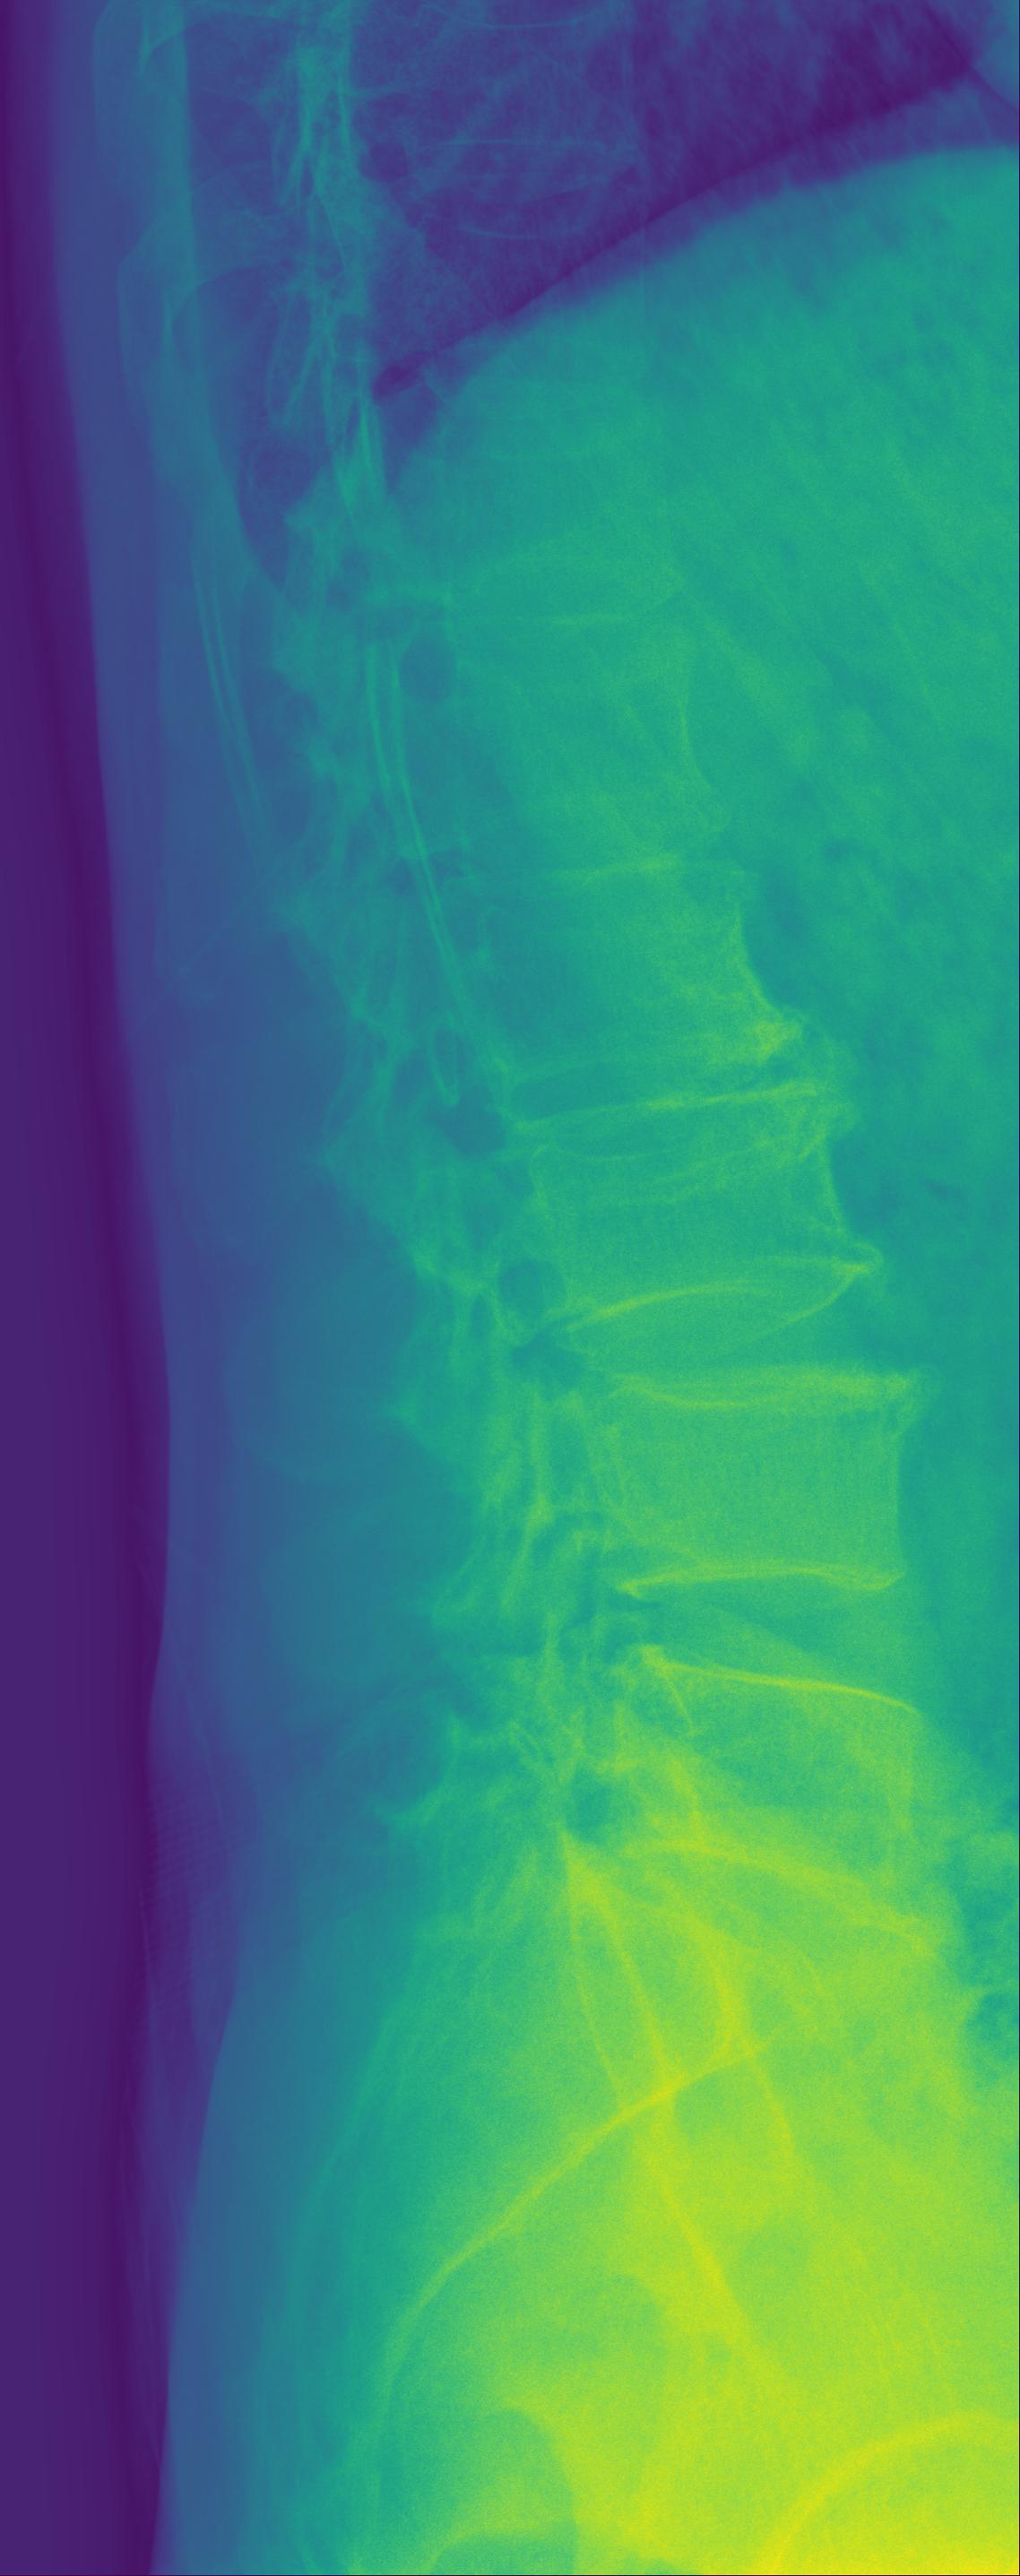

In [14]:
from IPython.display import Image
Image(filename='/media/bryan/3777c7d8-50a4-4e8a-9d41-1ac8670b3dd3/vindr/physionet.org/files/vindr-spinexr/tiny_vindr/train_images/ac8e211d4421d61cbdbcb09cdf56689b.jpg',width=150, height=150)

### We see that within the same study id 15354677a17156fbb5a617d694f2d25d we have ONE series id 1ace0c1895cd8314a54de49ce33777fe. We have two unique images associated with this single study-series combination. Therefore, 2+ images may appear as same study id and under the same series id.

In [27]:
### Get unique studies in train_csv
MICLe_image_dict = dict()
unique_studies_list = list(pd.unique(train_meta['study_id']))
for this_study in unique_studies_list:
    this_study_df = train_meta[train_meta['study_id']==this_study]
    study_unique_images = list(pd.unique(this_study_df['image_id']))
    if len(study_unique_images) > 1:
        MICLe_image_dict[this_study] = study_unique_images

In [34]:
### Per EDA above should be list of two images
print(MICLe_image_dict['d7f725fa068661e40db47afaf6811935'])
print(len(MICLe_image_dict))

['944a3478b664b658389013f512212562', 'e3b297bc7d0281331a674d107fb5d0eb']
2828


In [32]:
### Pickle MICLe_image_dict to give to Vinya
import pickle
with open('MICLe_image_dict.pickle', 'wb') as handle:
    pickle.dump(MICLe_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)